Istogrammi dei gradienti orientati.

Serve per dare una visualizzazione piu compatta di una immagine: le immagini non saranno più in pixels ma in istogrammi, in modo da favorire l'object detection.

L'algoritmo deve capire dove si trova l'oggetto nell'immagine, quindi vengono eliminate tutte le informazioni non utili ai fine dell'identificazione dell'oggetto. E' sufficiente definirie i controni dell'oggetto nell'immagine.

Vengono mantenute solo le features intressanti.

L'immagine di partenza 64 x 128 viene preprocessata e divisa da una griglia in quadratini di 8 x 8 pixels in cui vengono calcolati i gradienti (vettori di direzione e magnitude(modulo)) per assi x e y.
Vengono identificate le direzioni di massima variazione all'interno dell'immagine.

In [4]:
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

from skimage.feature import hog
from skimage import exposure,feature

from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

matplotlib.rcParams['figure.dpi']=300

DATASET_PATH='./Car_Brand_Logos/'
train_path=f"{DATASET_PATH}/Train"
test_path=f"{DATASET_PATH}/Test"

In [5]:
def show_images(left, right): #per far vedere due immagini una affianco all'altra
    fig, (ax1, ax2)= plt.subplots(1,2, figsize=(8,4), sharex=True, sharey=True)

    ax1.axis('off')
    ax1.imshow(left, cmap=plt.cm.gray)
    ax1.set_title('Input image')
    ax2.axis('off')
    ax2.imshow(right, cmap=plt.cm.gray)
    ax2.set_title('HOG representation')

    plt.show()

[0.02712339 0.02021658 0.02557217 ... 0.30021021 0.         0.        ]


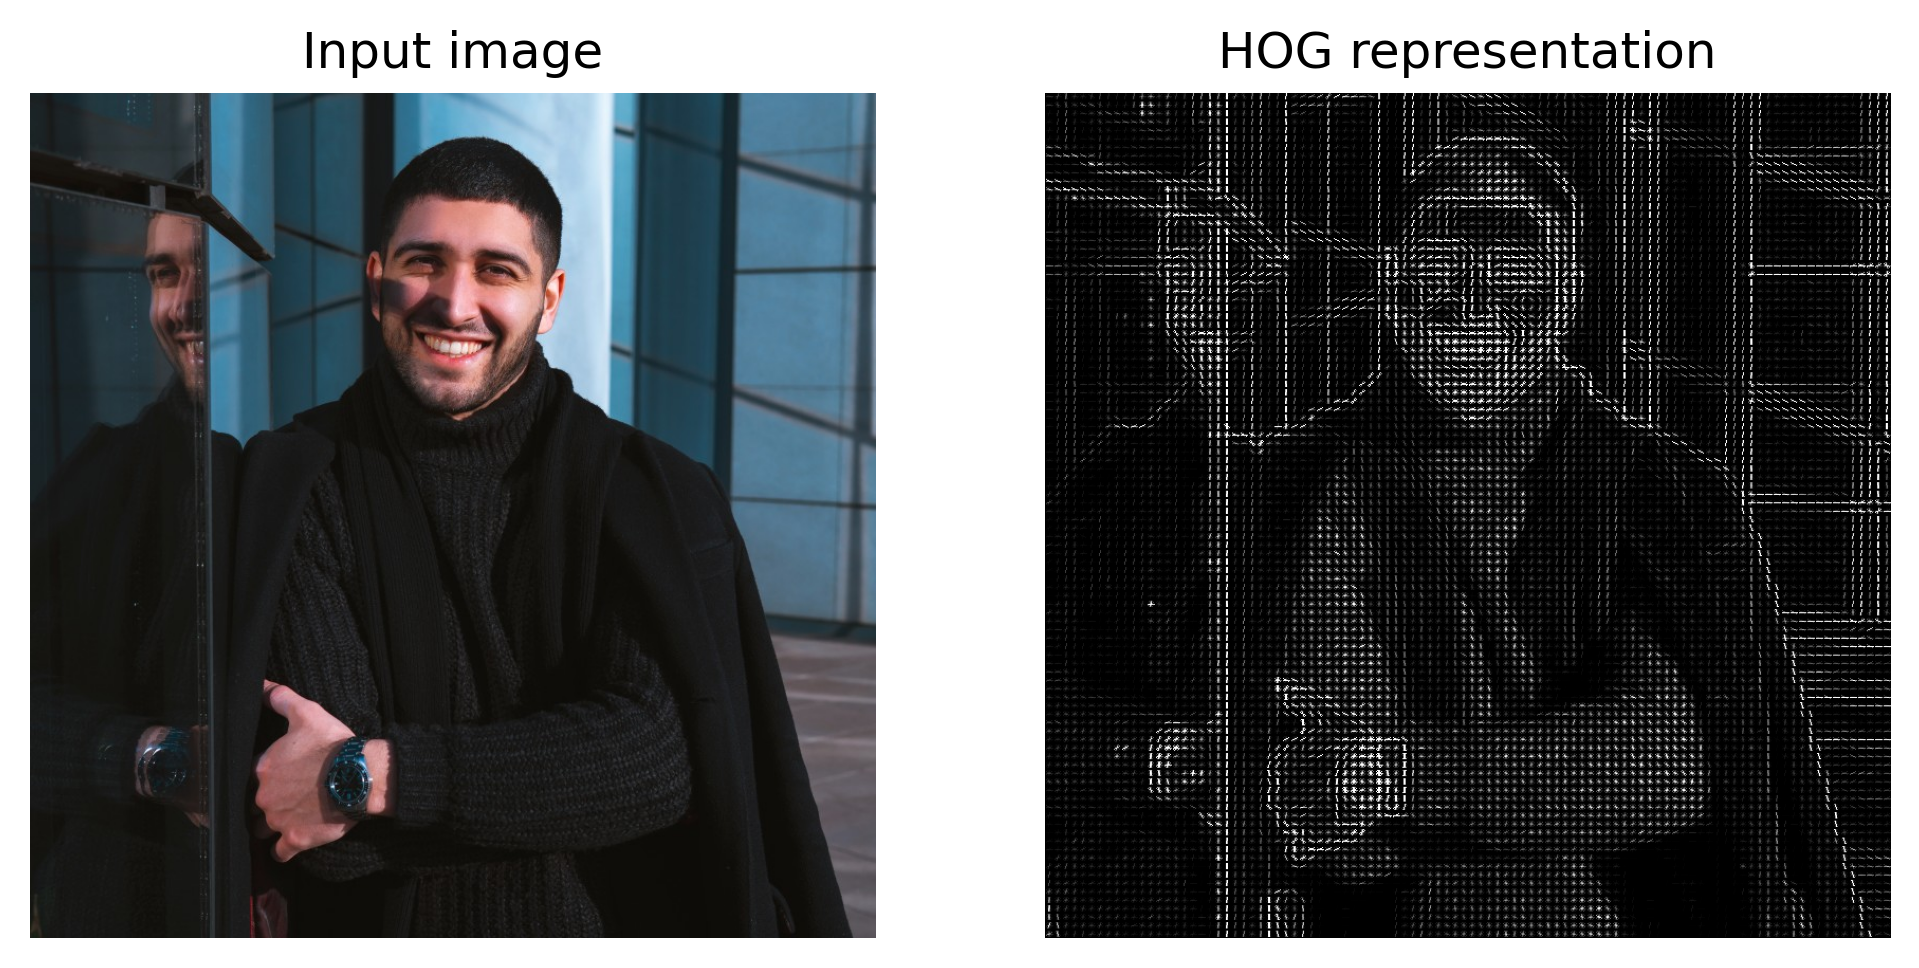

In [10]:
import requests
from io import BytesIO

url='https://media.licdn.com/dms/image/D4D03AQHhurZR30Hfcw/profile-displayphoto-shrink_800_800/0/1680347731842?e=2147483647&v=beta&t=MtCQY4EInIru2ZCjFpUI0wBjH-KxbCRLwiW7jhoNl9k'

response=requests.get(url)

image=Image.open(BytesIO(response.content))
histogram, hog_image= hog(
    image,
    orientations=9, #numero di colonne nell'istogramma
    pixels_per_cell=(8,8),
    cells_per_block=(2,2),
    visualize=True,
    channel_axis=-1
)

print(histogram)
hog_image_rescaled=exposure.rescale_intensity(hog_image, in_range=(0,8))
#scala i valori in pixels all'interno di 8 range, suddivido lo spazio in 8 intervalli, uso 8 livelli di bianco per avere una migliore rappresentazione visiva
show_images(image,hog_image_rescaled)

In [27]:
os.listdir(train_path) #lista dei loghi ordinati
#list compehension
labels=sorted([i for i in os.listdir(train_path) if i.startswith('.') is False])
print(labels)
print(len(labels))

['hyundai', 'lexus', 'mazda', 'mercedes', 'opel', 'skoda', 'toyota', 'volkswagen']
8


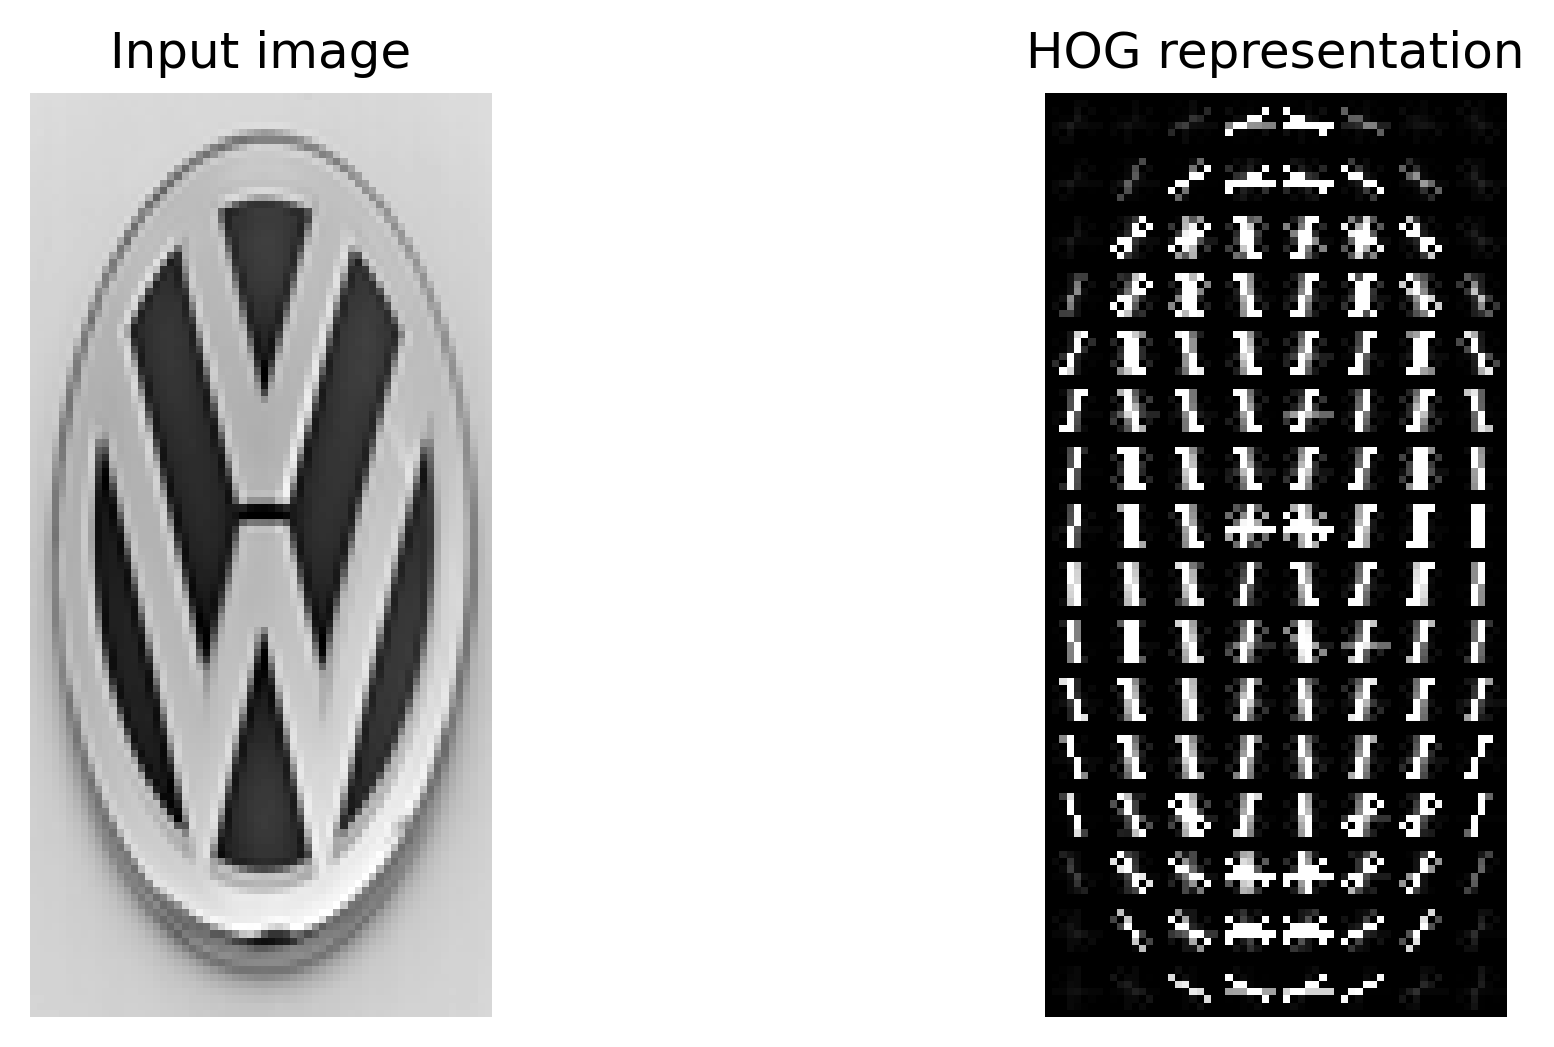

In [32]:
def preprocess_image(path):
    size=(64,128)
    image=Image.open(path)
    image=image.convert("L")
    image=image.resize(size, Image.Resampling.LANCZOS)
    return image

def get_hog_image(image, **params):
    return hog(
        image,
        **params #** serve per non passare i singoli parametri
    )

def create_dataset(path, output_classes):
    features=[ ]
    labels=[ ]
    for c in output_classes:
        print(f"---> Label {c}")
        for img in os.listdir(os.path.join(path, c)): #immagini raggruppate per cartella
            image=preprocess_image(os.path.join(path, c, img))
            image=np.asarray(image)
            try:
                features.append(
                    get_hog_image(
                        image,
                        transform_sqrt=True,
                        orientations=9,
                        pixels_per_cell=(8,8),
                        cells_per_block=(2,2),
                        block_norm="L1",
                    )
                )
                labels.append(c)
            except Exception as e:
                print(e)
                print(img, image.shape)

    return np.array(features), np.asarray(labels)
   
volkswagen_path=os.path.join(train_path, "volkswagen")
test_img=os.path.join(volkswagen_path, os.listdir(volkswagen_path)[0])

image=np.asarray(preprocess_image(test_img))

fd, hog_image = get_hog_image(
    image,
    visualize=True,
    transform_sqrt=False,
    orientations=9,
    pixels_per_cell=(8,8),
    cells_per_block=(3,3),
    block_norm="L1"
)

hog_image_rescaled=exposure.rescale_intensity(hog_image, in_range=(0,10))
show_images(image, hog_image_rescaled)


In [33]:
X_train, y_train=create_dataset(train_path, labels)
X_test, y_test= create_dataset(test_path, labels)
print(X_train[0].shape)
print(y_train[0])

---> Label hyundai
---> Label lexus
---> Label mazda
---> Label mercedes
---> Label opel
---> Label skoda
---> Label toyota
---> Label volkswagen
---> Label hyundai
---> Label lexus
---> Label mazda
---> Label mercedes
---> Label opel
---> Label skoda
---> Label toyota
---> Label volkswagen
(3780,)
hyundai


([<matplotlib.axis.XTick at 0x177a78280>,
 [Text(0, 0, 'hyundai'),
  Text(1, 0, 'lexus'),
  Text(2, 0, 'mazda'),
  Text(3, 0, 'mercedes'),
  Text(4, 0, 'opel'),
  Text(5, 0, 'skoda'),
  Text(6, 0, 'toyota'),
  Text(7, 0, 'volkswagen')])

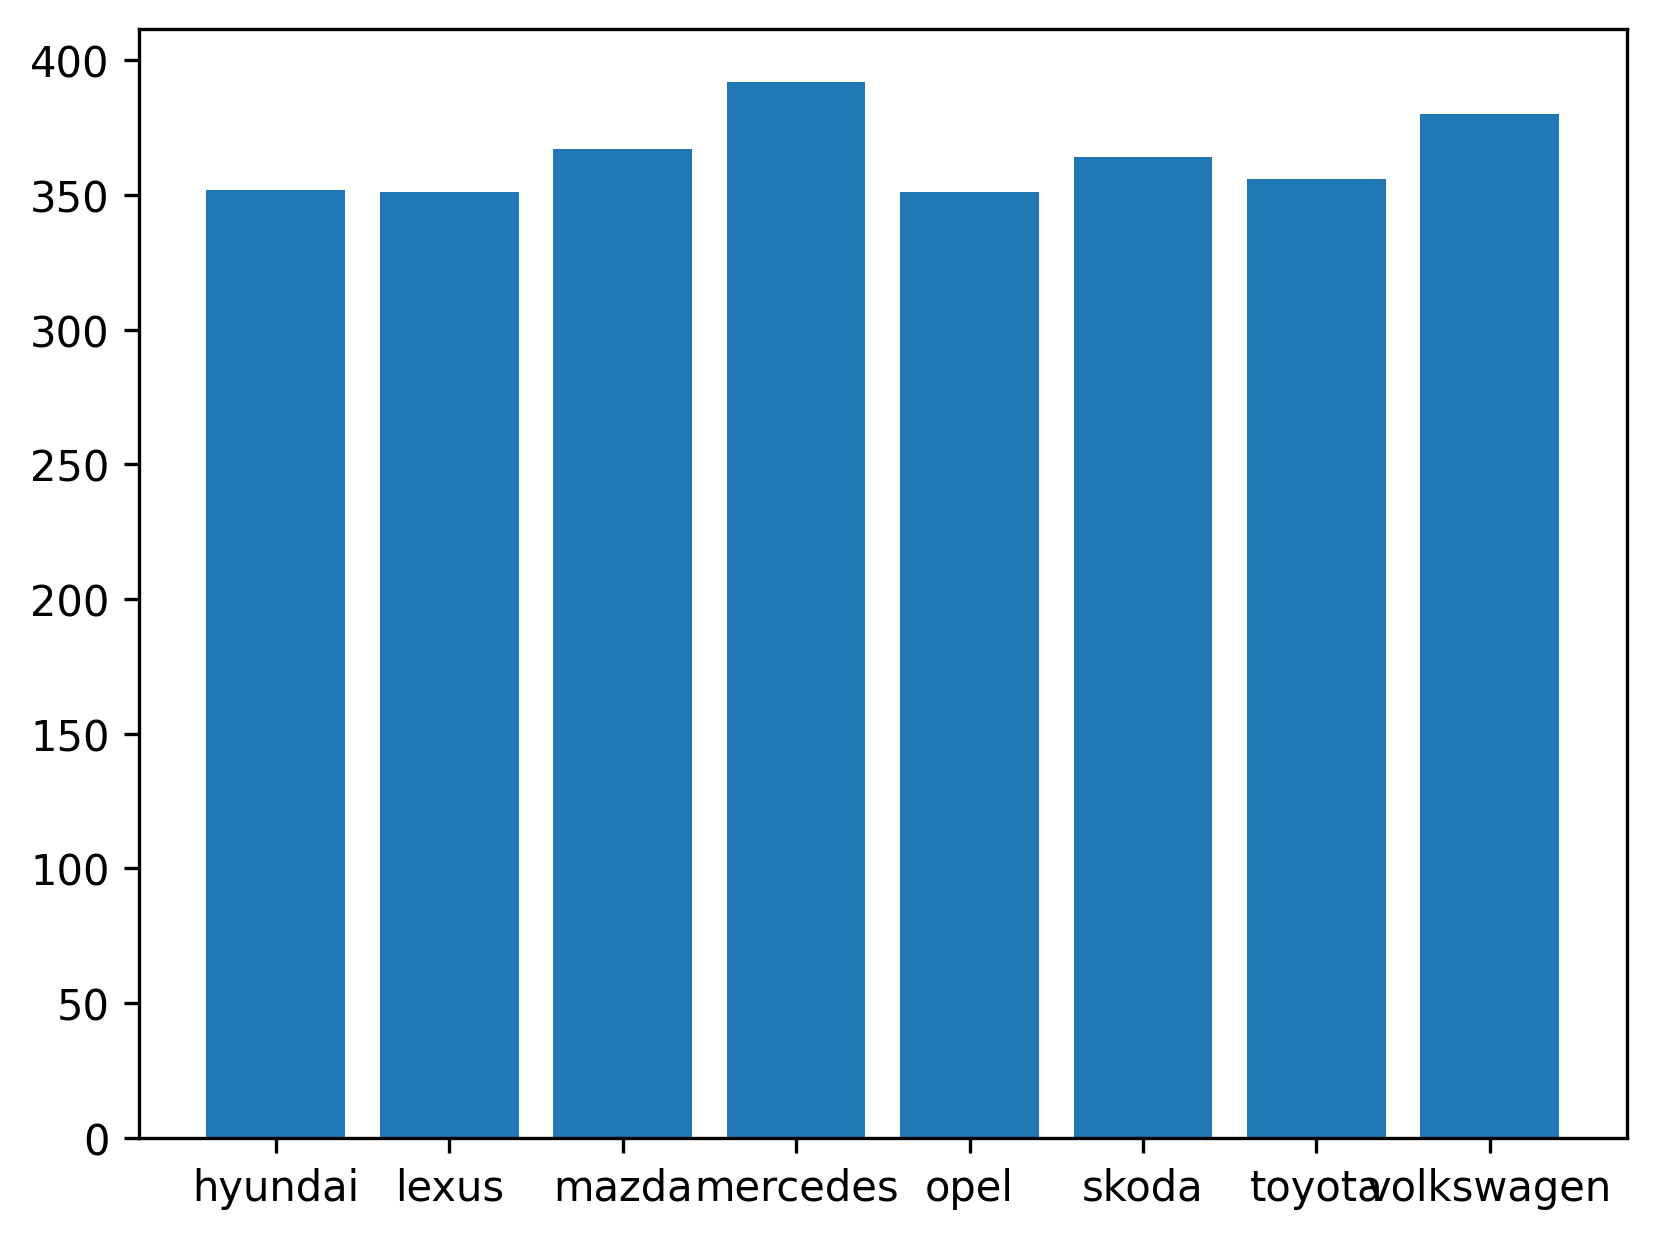

In [34]:
#cerchiamo di capire se il dataset è bilanciato o no
labels, counts= np.unique(np.concatenate((y_train,y_test)),return_counts=True)
ticks=range(len(counts))
plt.bar(labels, counts, align="center")
plt.xticks(ticks, labels)

Il dataset è abbastanza bilanciato 

In [35]:
C=1.0
start=time.time()
svc=svm.SVC(kernel="linear", C=C).fit(X_train, y_train)
rbf_svc=svm.SVC(kernel="rbf", gamma=0.7, C=C).fit(X_train, y_train)
poly_svc=svm.SVC(kernel="poly", degree=3, C=C).fit(X_train, y_train)
lin_svc=svm.LinearSVC(C=C).fit(X_train, y_train)

print(f"Cell execution time: {time.time()-start} seconds")

/Users/uffa/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Cell execution time: 61.6915500164032 seconds


In [36]:
svc_predictions=svc.score(X_test, y_test)
print("Linear kernel accuracy -> ", svc_predictions)

rbf_predictions=rbf_svc.score(X_test, y_test)
print("Rbf kernel accuracy -> ", rbf_predictions)

poly_predictions=poly_svc.score(X_test, y_test)
print("Poly kernel accuracy -> ", poly_predictions)

lin_predictions=lin_svc.score(X_test, y_test)
print("Linear kernel accuracy -> ", lin_predictions)


Linear kernel accuracy ->  0.5825
Rbf kernel accuracy ->  0.4175
Poly kernel accuracy ->  0.6425
Linear kernel accuracy ->  0.6025


In [37]:
start = time.time()

param_grid= {"C":[150,100,10], 
             "gamma":[1,0.5,0.1], 
             "degree": [2,3,4],
             "kernel": ["linear", "rbf", "poly", "sigmoid"]}

grid=GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train,y_train)

print(f"Cell execution time: {time.time()-start} seconds")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END ............C=150, degree=2, gamma=1, kernel=linear; total time=  11.1s
[CV] END ............C=150, degree=2, gamma=1, kernel=linear; total time=  11.0s
[CV] END ............C=150, degree=2, gamma=1, kernel=linear; total time=  10.7s
[CV] END ............C=150, degree=2, gamma=1, kernel=linear; total time=  11.4s
[CV] END ............C=150, degree=2, gamma=1, kernel=linear; total time=  11.1s
[CV] END ...............C=150, degree=2, gamma=1, kernel=rbf; total time=  15.3s
[CV] END ...............C=150, degree=2, gamma=1, kernel=rbf; total time=  15.3s
[CV] END ...............C=150, degree=2, gamma=1, kernel=rbf; total time=  15.3s
[CV] END ...............C=150, degree=2, gamma=1, kernel=rbf; total time=  15.3s
[CV] END ...............C=150, degree=2, gamma=1, kernel=rbf; total time=  15.3s
[CV] END ..............C=150, degree=2, gamma=1, kernel=poly; total time=  13.1s
[CV] END ..............C=150, degree=2, gamma=

In [38]:
print(grid.best_params_)

{'C': 10, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}


In [39]:
grid_predictions=grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test, grid_predictions))

[[34  1  3  3  0  3  3  3]
 [ 2 37  1  2  1  4  1  2]
 [ 1  1 42  1  0  3  2  0]
 [ 1  4  4 36  0  2  1  2]
 [ 1  4  3  2 28  6  3  3]
 [ 4  2  5  2  1 24  6  6]
 [ 0  5  2  6  5  2 25  5]
 [ 1  4  0  0  1  9  4 31]]
              precision    recall  f1-score   support

     hyundai       0.77      0.68      0.72        50
       lexus       0.64      0.74      0.69        50
       mazda       0.70      0.84      0.76        50
    mercedes       0.69      0.72      0.71        50
        opel       0.78      0.56      0.65        50
       skoda       0.45      0.48      0.47        50
      toyota       0.56      0.50      0.53        50
  volkswagen       0.60      0.62      0.61        50

    accuracy                           0.64       400
   macro avg       0.65      0.64      0.64       400
weighted avg       0.65      0.64      0.64       400



In [40]:
m=svm.SVC(probability=True, **grid.best_params_)
m.fit(X_train,y_train)

SVC(C=10, degree=2, gamma=0.1, kernel='poly', probability=True)

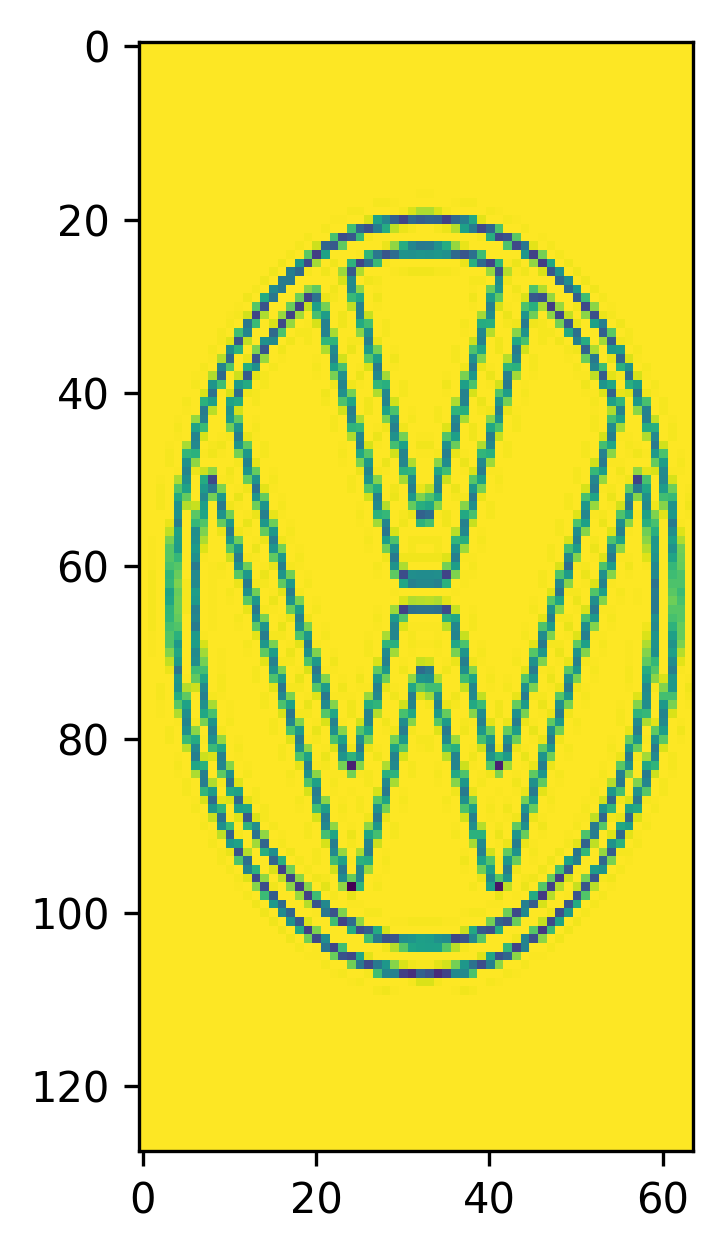

In [41]:
img=preprocess_image(os.path.join(test_path, "volkswagen","images41.jpg"))
plt.imshow(img)

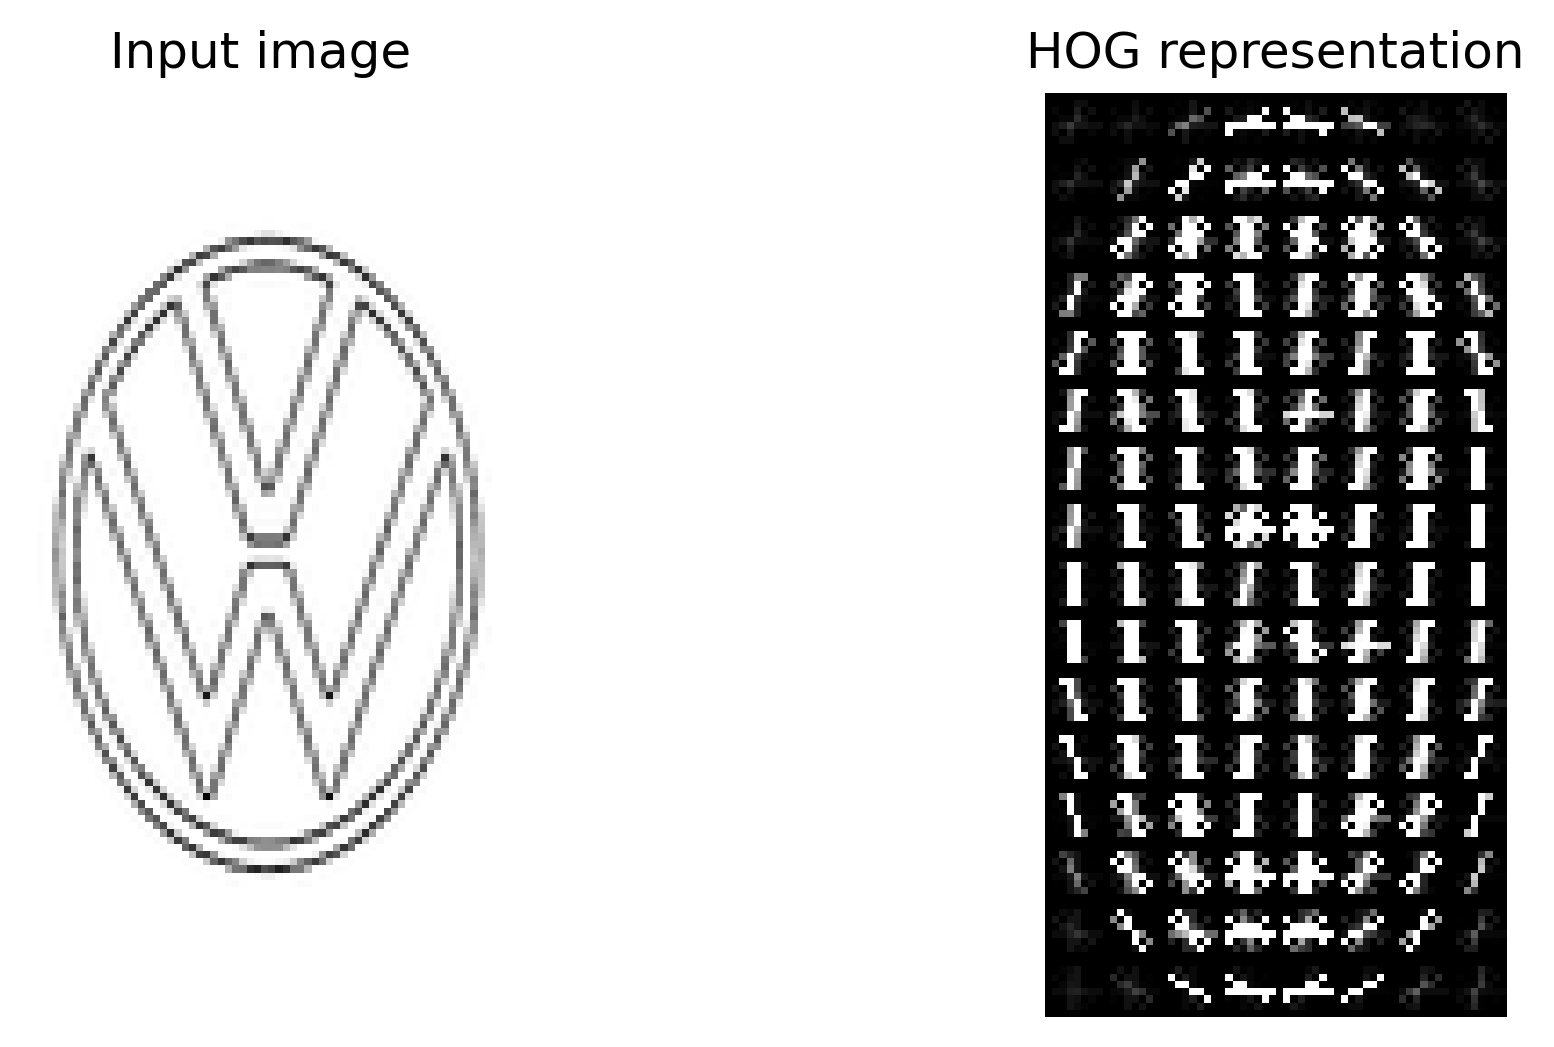

In [42]:
fd, hog_image = get_hog_image(
    image,
    visualize=True,
    transform_sqrt=False,
    orientations=9,
    pixels_per_cell=(8,8),
    cells_per_block=(2,2),
    block_norm="L1"
)

hog_image_rescaled=exposure.rescale_intensity(hog_image, in_range=(0,5))
show_images(img, hog_image_rescaled)

In [43]:
print(m.classes_)
print(m.predict_proba([fd]))
print(m.predict([fd]))
#restituisce la classe volkswagen

['hyundai' 'lexus' 'mazda' 'mercedes' 'opel' 'skoda' 'toyota' 'volkswagen']
[[0.00331234 0.0046567  0.00373597 0.00101031 0.00476455 0.00251913
  0.00714761 0.97285338]]
['volkswagen']
